# Data analyzis of the MGZ mission

This Jupiter Notebook makes basic analyzis and refinement on the measured datas of our CanSat when our data sources are updated and our notebook is restarted. Dou to the fact that our mission is a one time flight, this technique is a bit overcomplicated and unnescessarily robust. However, this method of data analyzis makes reusability a possibility and testing less time consuming. Our scripts are designed to be easily readable and usable on other windows computers as well. This makes collaboration accessible and less problematic. These are crucial aspects on an offical mission, which we aim to replicate to the best of our ability.

For more information, read the README.md document.

## Setup and sorting

Before we start the analyzis we have to include the necessary modules and libraries. We will try to make sure that our code is bulletproof aganist all types of errors and easily fixable by using error handling. Let's organize our measurements using OOP. In addition, we are able set test_data_mode = True which generates test values for the notebook. If an organized database is avalible, we are able to set only_analizys_mode = True. This drastically reduces execution time.

In [11]:
__author__ = "KarmaDemon"

# Select the modes of the program
TEST_DATA_MODE = True
ONLY_ANALYZIS_MODE = True
INTO_PDF = False

# Txt and database names
TXT_NAME = "raw_data.txt"
DATABASE_NAME = "datas/raw_data.db"

# CanSat attributes and conditions
DRAG_COEFFICIENT = 0.5
AIR_DENSITY = 1.225  # kg/m^3 (standard atmospheric model)
SURFACE_AREA = 0.1  # m^2 (assumed cross-sectional area)
MASS = 1.0  # kg (assumed mass)

# Import the necessary modules
import pickle
import os
import sys
import subprocess
import traceback
import math

try:
    import program_files.cansattools as cansattools
except ImportError:
    print("The execution failed. The cansattools module can't be imported.")
    sys.exit(1)
try:
    logger = cansattools.logger_creator("jupyter_notebook")
except ImportError:
    logger = None
    print("Error importing cansattools module. Logging is disabled.")

try:
    #from mpl_toolkits import mplot3d
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from mpl_toolkits.mplot3d import Axes3D
    %matplotlib inline
    import program_files.classes as classes
    import sqlite3
    from sqlite3 import Error
except ImportError as e:
    logger.error(f"Error importing modules: {e}")

# Store the data in classes
bmp280: list[classes.BMP280] = []
dht11: list[classes.DHT11] = []
gpses: list[classes.GPS] = []
mpu6050: list[classes.MPU6050] = []

if not ONLY_ANALYZIS_MODE:
    #create or replace database
    cansattools.create_db(DATABASE_NAME, replace_mode=True)
    if TEST_DATA_MODE:
        bmp_current = classes.BMP280(0, 30, 4000.0, 100.0)
        dht_current = classes.DHT11(0, 50.0)
        for i in range(0, 2000):
            bmp280.append(bmp_current)
            dht11.append(dht_current)
            bmp_current.time = cansattools.test_data_generator(bmp_current.time, 3000000, 0, 20, True)
            bmp_current.temperature = cansattools.test_data_generator(bmp_current.temperature, 100, -100, 5)
            bmp_current.pressure = cansattools.test_data_generator(bmp_current.pressure, 100000, 0, 20)
            bmp_current.height = cansattools.test_data_generator(bmp_current.height, 1000, 20, 20)
            dht_current.time = cansattools.test_data_generator(dht_current.time, 3000000, 0, 5, True)
            dht_current.humidity = cansattools.test_data_generator(dht_current.humidity, 100, 0, 5)
            bmp_current = classes.BMP280(bmp_current.time, bmp_current.temperature, bmp_current.pressure, bmp_current.height)
            dht_current = classes.DHT11(dht_current.time, dht_current.humidity)

        gps_current = classes.GPS(0, 0.0, 0.0, 0.0)
        for i in range(0, 80):
            gpses.append(gps_current)
            gps_current.time = cansattools.test_data_generator(gps_current.time, 3000000, 0, 400, True)
            gps_current.latitude = cansattools.test_data_generator(gps_current.latitude, 90, -90, 20)
            gps_current.longitude = cansattools.test_data_generator(gps_current.longitude, 180, -180, 20)
            gps_current.altitude = cansattools.test_data_generator(gps_current.altitude, 1000, 20, 20)
            gps_current = classes.GPS(gps_current.time, gps_current.latitude, gps_current.longitude, gps_current.altitude)    
    else:
        # Open the txt file and read the data
        try:
            with open(f"datas/{TXT_NAME}", "r") as file:
                data = file.readlines()
        except FileNotFoundError:
            try:
                with open(f"{TXT_NAME}", "r") as file:
                    data = file.readlines()
            except FileNotFoundError:
                logger.error(f"File {TXT_NAME} not found")

        for line in data:
            try:
                if "BMP280" in line:
                    bmp280.append(classes.BMP280(line.split()[1:]))
                elif "DHT11" in line:
                    dht11.append(classes.DHT11(line.split()[1:]))
                elif "GPS" in line:
                    gpses.append(classes.GPS(line.split()[1:]))
                elif "MPU6050" in line:
                    mpu6050.append(classes.MPU6050(line.split()[1:]))
            except Exception as e:
                logger.error(f"Error inserting data into the classes: {e}")

        # Insert the data into the SQLite database
        cansattools.txt_to_db(data, DATABASE_NAME)

        # Clear the data
        data = None
else:
    try:
        conn = sqlite3.connect(DATABASE_NAME)
        c = conn.cursor()
    except Error as e:
        logger.error(f"Error connecting to the database: {e}")
    try:
        # Get length of the table
        c.execute("SELECT COUNT(*) FROM BMP280")
        conn.commit()
        bmp280_length = c.fetchone()[0]
        c.execute("SELECT COUNT(*) FROM DHT11")
        conn.commit()
        dht11_length = c.fetchone()[0]
        c.execute("SELECT COUNT(*) FROM GPS")
        conn.commit()
        gps_length = c.fetchone()[0]
        c.execute("SELECT COUNT(*) FROM MPU6050")
        conn.commit()
        mpu6050_length = c.fetchone()[0]
        # Get the data from the table
        for i in range(1, bmp280_length):
            bmp_current = classes.BMP280(0, 0.0, 0.0, 0.0)
            bmp_current.read_from_db(table_name="BMP280", index=i, conn=conn, c=c)
            bmp280.append(bmp_current)
        for i in range(1, dht11_length):
            dht_current = classes.DHT11(0, 0.0)
            dht_current.read_from_db(table_name="DHT11", index=i, conn=conn, c=c)
            dht11.append(dht_current)
        for i in range(1, gps_length):
            gps_current = classes.GPS(0, 0.0, 0.0, 0.0)
            gps_current.read_from_db(table_name="GPS", index=i, conn=conn, c=c)
            gpses.append(gps_current)
        for i in range(1, mpu6050_length):
            mpu6050_current = classes.MPU6050(0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
            mpu6050_current.read_from_db(table_name="MPU6050", index=i, conn=conn, c=c)
            mpu6050.append(mpu6050_current)
    except Error as e:
        logger.error(f"Error inserting data into the objects: {e}")
    try:
        conn.close()
    except Error as e:
        logger.error(f"Error closing the database connection: {e}")

## Raw data visualization

First of all, let's have a look at our measured datas by each sensor on graphs. Due to the sensors' inaccuracies there may be outliers.

### BMP280

Fortunately, the BMP280 measurements are available. Therefore, we can plot the data.
The amount of data provided by the BMP280 sensor is:  1998


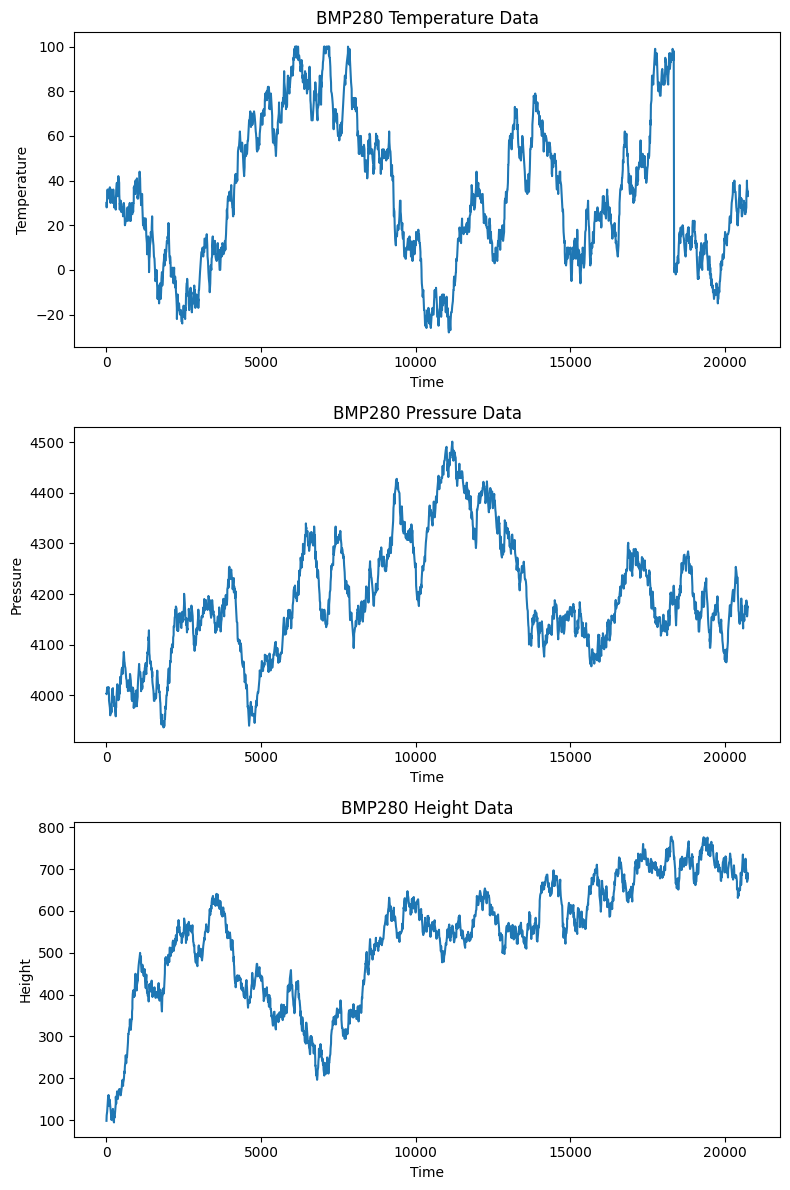

In [12]:
try:
    if len(bmp280) > 0:
        print("Fortunately, the BMP280 measurements are available. Therefore, we can plot the data.")
        print("The amount of data provided by the BMP280 sensor is: ", len(bmp280))
        fig: plt.Figure
        axs: plt.Axes
        fig, axs= plt.subplots(3, figsize=(8, 12))

        axs[0].plot([bmp.time for bmp in bmp280], [bmp.temperature for bmp in bmp280], '-')
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Temperature')
        axs[0].set_title('BMP280 Temperature Data')

        axs[1].plot([bmp.time for bmp in bmp280], [bmp.pressure for bmp in bmp280], '-')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('Pressure')
        axs[1].set_title('BMP280 Pressure Data')

        axs[2].plot([bmp.time for bmp in bmp280], [bmp.height for bmp in bmp280], '-')
        axs[2].set_xlabel('Time')
        axs[2].set_ylabel('Height')
        axs[2].set_title('BMP280 Height Data')

        plt.tight_layout()
        try:
            if os.path.exists('graphs/pngs/BMP_raw.png'):
                os.remove('graphs/pngs/BMP_raw.png')
            plt.savefig('graphs/pngs/BMP_raw.png', format='png')
            with open('graphs/pkls/BMP_raw.pkl', 'wb') as file:
                pickle.dump(fig, file)
        except Exception as e:
            logger.error(f"Error saving the BMP280 data: {e}")
        plt.show()
    else:
        print("Unfortunately, the BMP280 measurements are not available. Therefore, we cannot plot the data as expected.")
except Exception as e:
    logger.error(f"Error visualizing data: {e}")

### DHT11

Fortunately, the DHT11 measurements are available. Therefore, we can plot the data.
The amount of data provided by the DHT11 sensor is:  1998


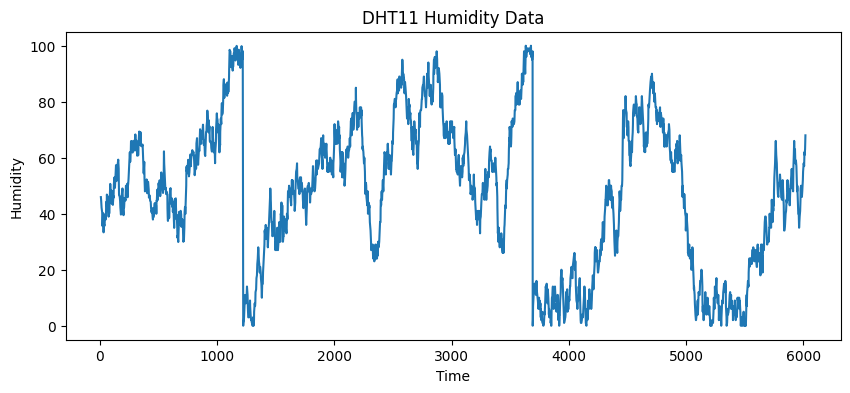

In [13]:
try:
    if len(dht11) > 0:
        print("Fortunately, the DHT11 measurements are available. Therefore, we can plot the data.")
        print("The amount of data provided by the DHT11 sensor is: ", len(dht11))
        fig = plt.figure(figsize=(10, 4))
        plt.plot([dht.time for dht in dht11], [dht.humidity for dht in dht11], '-')
        plt.xlabel('Time')
        plt.ylabel('Humidity')
        plt.title('DHT11 Humidity Data')
        try:
            if os.path.exists('graphs/pngs/DHT_raw.png'):
                os.remove('graphs/pngs/DHT_raw.png')
            plt.savefig('graphs/pngs/DHT_raw.png', format='png')
            with open('graphs/pkls/DHT_raw.pkl', 'wb') as file:
                pickle.dump(fig, file)
        except Exception as e:
            logger.error(f"Error saving the DHT11 data: {e}")
        plt.show()
    else:
        print("Unfortunately, the DHT11 measurements are not available. Therefore, we cannot plot the data as expected.")
except Exception as e:
    logger.error(f"Error visualizing data: {e}")

### GPS

We can create a 3 dimentional map of the gps measurements. Unfortunetly, the altitude data cannot always be measured due to communicational problems. This can cause inaccuracies in the illustration. The passage of time is indicated with changing colors.

Fortunately, the GPS measurements are available. Therefore, we can plot the data.
The amount of data provided by the GPS sensor is:  78


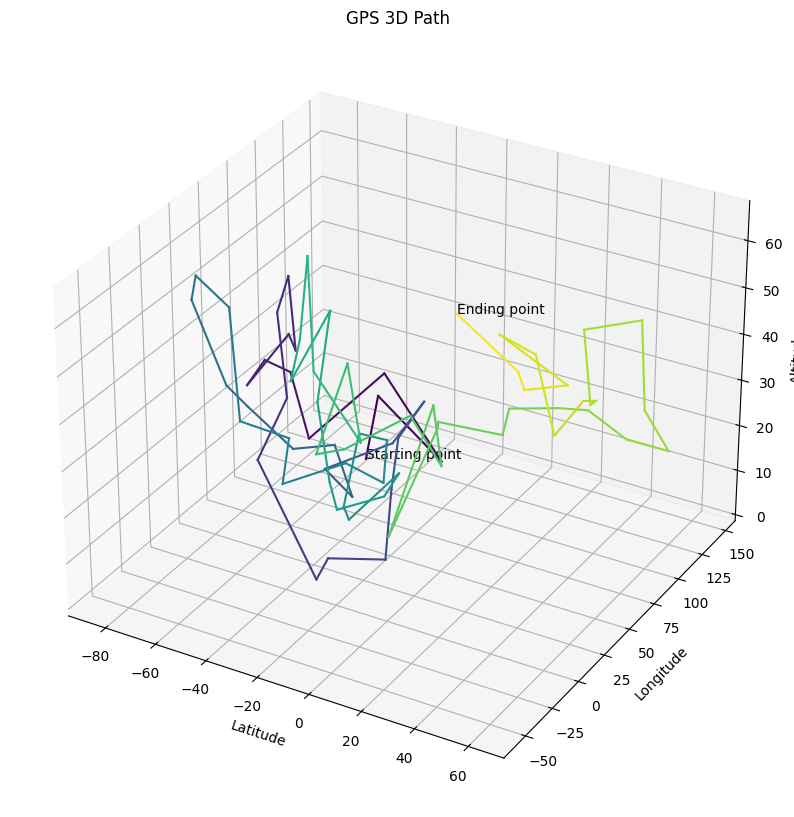

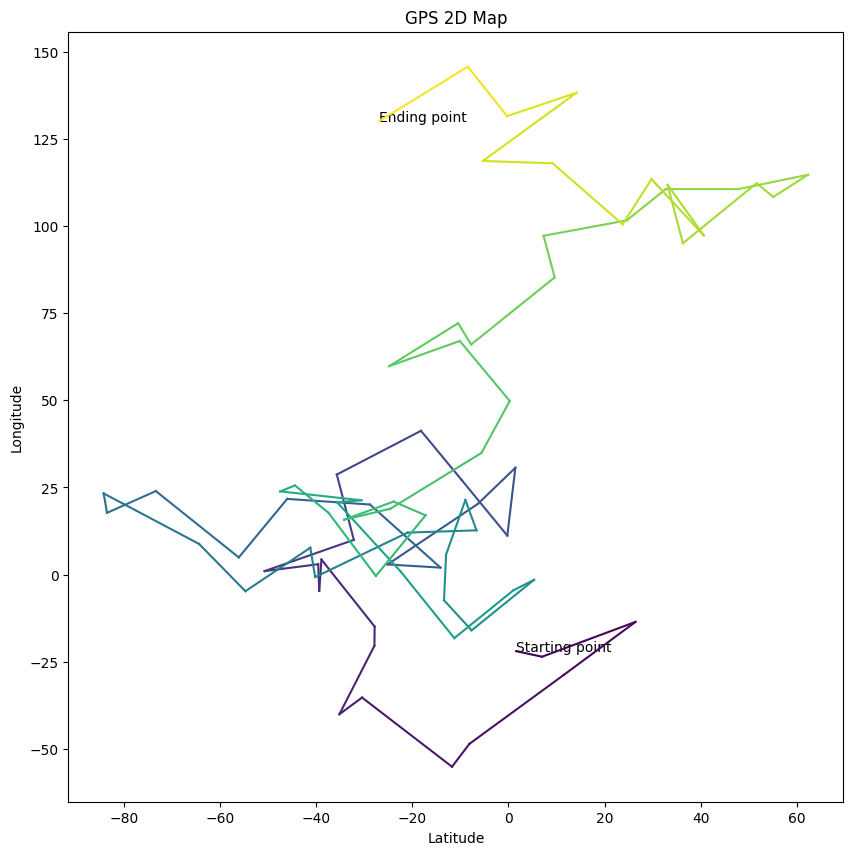

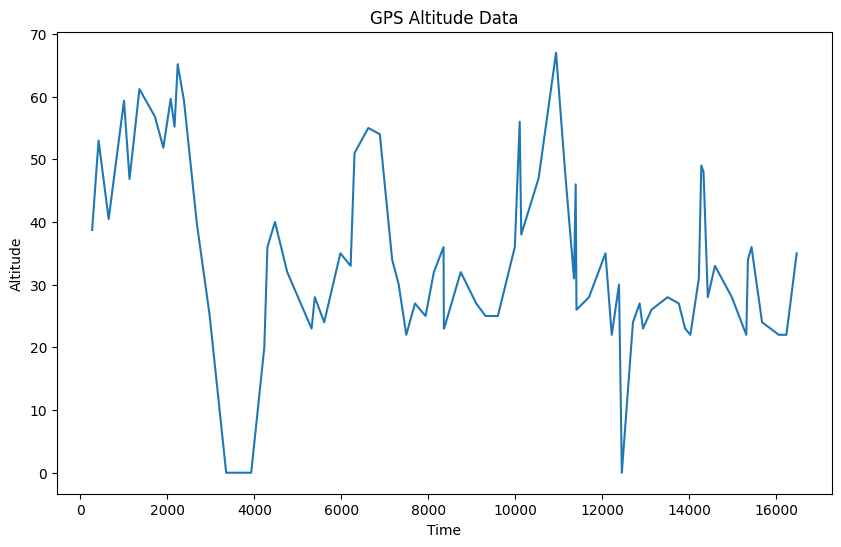

In [14]:
try:
    if len(gpses) > 0:
        print("Fortunately, the GPS measurements are available. Therefore, we can plot the data.")
        print("The amount of data provided by the GPS sensor is: ", len(gpses))

        cmap = plt.get_cmap('viridis')
        times = np.array([gps.time for gps in gpses])
        normalized_times = (times - times.min()) / (times.max() - times.min())
        colors = cmap(normalized_times)
        
        # Plot the GPS data
        fig = plt.figure(figsize=(10, 14))
        
        # 3D path map
        ax = plt.axes(projection='3d')
        for i in range(len(gpses) - 1):
            ax.plot3D([gpses[i].latitude, gpses[i+1].latitude], 
                        [gpses[i].longitude, gpses[i+1].longitude], 
                        [gpses[i].altitude, gpses[i+1].altitude], 
                        color=colors[i])
        ax.text(gpses[0].latitude, gpses[0].longitude, gpses[0].altitude, 'Starting point', size=10, zorder=1, color='k')
        ax.text(gpses[-1].latitude, gpses[-1].longitude, gpses[-1].altitude, 'Ending point', size=10, zorder=1, color='k')
        ax.set_xlabel('Latitude')
        ax.set_ylabel('Longitude')
        ax.set_zlabel('Altitude')
        ax.set_title('GPS 3D Path')
        try:
            if os.path.exists('graphs/pngs/GPS_3D_raw.png'):
                os.remove('graphs/pngs/GPS_3D_raw.png')
            plt.savefig('graphs/pngs/GPS_3D_raw.png', format='png')
            with open('graphs/pkls/GPS_3D_raw.pkl', 'wb') as file:
                pickle.dump(fig, file)
        except Exception as e:
            logger.error(f"Error saving the GPS data: {e}")
        plt.show()

        # 2D map
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        for i in range(len(gpses) - 1):
            ax.plot([gpses[i].latitude, gpses[i+1].latitude], [gpses[i].longitude, gpses[i+1].longitude], '-', color=colors[i])
        ax.text(gpses[0].latitude, gpses[0].longitude, 'Starting point', size=10, zorder=1, color='k')
        ax.text(gpses[-1].latitude, gpses[-1].longitude, 'Ending point', size=10, zorder=1, color='k')
        ax.set_xlabel('Latitude')
        ax.set_ylabel('Longitude')
        ax.set_title('GPS 2D Map')
        try:
            if os.path.exists('graphs/pngs/GPS_2D_raw.png'):
                os.remove('graphs/pngs/GPS_2D_raw.png')
            plt.savefig('graphs/pngs/GPS_2D_raw.png', format='png')
            with open('graphs/pkls/GPS_2D_raw.pkl', 'wb') as file:
                pickle.dump(fig, file)
        except Exception as e:
            logger.error(f"Error saving the GPS data: {e}")
        plt.show()

        # 2D altitude-time graph
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111)
        ax.plot([gps.time for gps in gpses], [gps.altitude for gps in gpses], '-')
        ax.set_xlabel('Time')
        ax.set_ylabel('Altitude')
        ax.set_title('GPS Altitude Data')
        try:
            if os.path.exists('graphs/pngs/GPS_altitude-time_raw.png'):
                os.remove('graphs/pngs/GPS_altitude-time_raw.png')
            plt.savefig('graphs/pngs/GPS_altitude-time_raw.png', format='png')
            with open('graphs/pkls/GPS_altitude-time_raw.pkl', 'wb') as file:
                pickle.dump(fig, file)
        except Exception as e:
            logger.error(f"Error saving the GPS data: {e}")
        plt.show()
    else:
        print("Unfortunately, the GPS measurements are not available. Therefore, we cannot plot the data as expected.")
except Exception as e:
    logger.error(f"Error visualizing GPS datas: {e}")

### MPU6050

## Refining datas

For proper analyzis we should refine the measured datas. This includes the detection of lacking data provision and outliers. The refined values will be stored in a database.

In [15]:
if not ONLY_ANALYZIS_MODE:
    # Fill objects with test data and insert them into the database
    try:
        conn = sqlite3.connect(DATABASE_NAME)
        c = conn.cursor()
    except Error as e:
        logger.error(f"Error connecting to the database: {e}")

    #calculate maximum altitude and index
    max_altitude = max(bmp.height for bmp in bmp280)
    max_altitude_index = bmp280.index([bmp for bmp in bmp280 if bmp.height == max_altitude][0])

    #We should set different values for the launch and for the descent
    try:
        for i, bmp in enumerate(bmp280[1:max_altitude_index], start=1):
            previous_bmp = bmp280[i-1]
            bmp.refine(previous_object=previous_bmp, outlier_step_threshold=18, outlier_iqr_multiplier=1.5, lacking_data_threshold=100)
            bmp.insert_into_db("BMP280", c)
        for i, bmp in enumerate(bmp280[max_altitude_index:], start=max_altitude_index+1):
            previous_bmp = bmp280[i-1]
            bmp.refine(previous_object=previous_bmp, outlier_step_threshold=11, outlier_iqr_multiplier=1.2, lacking_data_threshold=100)
            bmp.insert_into_db("BMP280", c)
    except Error as e:
        logger.error(f"Error inserting BMP280 data into the database: {e}")
    except Exception as e:
        logger.error(f"Error refining BMP280 data: {e}")

    try:
        for i, dht in enumerate(dht11[1:], start=1):
            previous_dht = dht11[i-1]
            dht.refine(previous_object=previous_dht, outlier_iqr_multiplier=1.5, lacking_data_threshold=100)
            dht.insert_into_db("DHT11", c)
    except Error as e:
        logger.error(f"Error inserting DHT11 data into the database: {e}")
    except Exception as e:
        logger.error(f"Error refining DHT11 data: {e}")

    try:
        for i, gps in enumerate(gpses[1:], start=1):
            previous_gps = gpses[i-1]
            gps.refine(previous_object=previous_gps, outlier_iqr_multiplier=1.5, lacking_data_threshold=500)
            gps.insert_into_db("GPS", c)
    except Error as e:
        logger.error(f"Error inserting GPS data into the database: {e}")
    except Exception as e:
        logger.error(f"Error refining GPS data: {e}")

    try:
        for i, mpu in enumerate(mpu6050[1:], start=1):
            previous_mpu = mpu6050[i-1]
            mpu.refine(previous_object=previous_mpu, outlier_iqr_multiplier=1.5, lacking_data_threshold=100)
            mpu.insert_into_db("MPU6050", c)
    except Error as e:
        logger.error(f"Error inserting MPU6050 data into the database: {e}")
    except Exception as e:
        logger.error(f"Error refining MPU6050 data: {e}")

    try:
        conn.commit()
        conn.close()
    except Error as e:
        logger.error(f"Error committing changes to the database: {e}")

### Visualization of refined datas

Let's visualize the refined datas for comparition aganist the raw datas.

Number of missing data points:  285
Number of outliers:  278


C:\Users\Siket Arnold Ádám\AppData\Local\Temp\ipykernel_51068\3041956444.py:64: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('graphs/pngs/BMP_refined.png', format='png')
C:\Users\Siket Arnold Ádám\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


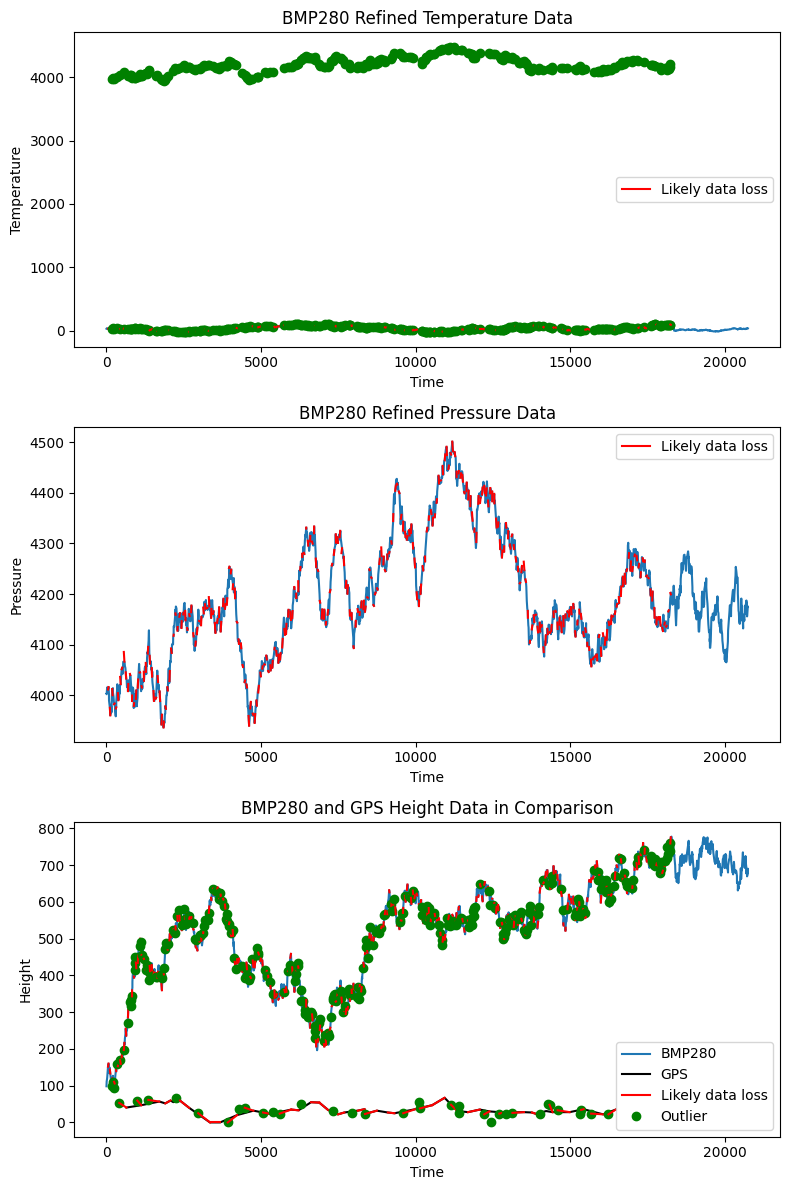

In [16]:
try:
    first_time = True
    if len(bmp280) > 0:
        print("Number of missing data points: ", sum(1 for bmp in bmp280 if bmp.missing_data))
        print("Number of outliers: ", sum(1 for bmp in bmp280 if bmp.is_outlier))
        fig: plt.Figure
        axs: plt.Axes
        fig, axs= plt.subplots(3, figsize=(8, 12))

        axs[0].plot([bmp.time for bmp in bmp280 if not bmp.is_outlier], [bmp.temperature for bmp in bmp280 if not bmp.is_outlier], '-')
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Temperature')
        axs[0].set_title('BMP280 Refined Temperature Data')
        for i, bmp in enumerate(bmp280[1:], start=1):
            if bmp.missing_data: #weird
                axs[0].plot([bmp280[i-1].time, bmp.time], [bmp280[i-1].temperature, bmp.temperature], '-', color='red', label='Likely data loss' if first_time else '') 
                first_time = False
            if bmp.is_outlier: #weird stuff
                axs[0].plot([bmp.time], [bmp.temperature], 'o', color='green', label='Outlier' if first_time_outlier else '') 
                first_time_outlier = False
        axs[0].legend()
        first_time = True
        first_time_outlier = True

        axs[1].plot([bmp.time for bmp in bmp280 if not bmp.is_outlier], [bmp.pressure for bmp in bmp280 if not bmp.is_outlier], '-')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('Pressure')
        axs[1].set_title('BMP280 Refined Pressure Data')
        for i, bmp in enumerate(bmp280[1:], start=1):
            if bmp.missing_data:
                axs[1].plot([bmp280[i-1].time, bmp.time], [bmp280[i-1].pressure, bmp.pressure], '-', color='red', label='Likely data loss' if first_time else '') 
                first_time = False
            if bmp.is_outlier:
                axs[0].plot([bmp.time], [bmp.pressure], 'o', color='green', label='Outlier' if first_time_outlier else '') 
                first_time_outlier = False
        axs[1].legend()
        first_time = True
        first_time_outlier = True

        # Visualize height data(comparing bmp280 and gps with different colors)
        axs[2].plot([bmp.time for bmp in bmp280 if not bmp.is_outlier], [bmp.height for bmp in bmp280 if not bmp.is_outlier], '-', label='BMP280')
        axs[2].plot([gps.time for gps in gpses if not gps.is_outlier], [gps.altitude for gps in gpses if not gps.is_outlier], '-', color='black', label='GPS')
        axs[2].set_xlabel('Time')
        axs[2].set_ylabel('Height')
        axs[2].set_title('BMP280 and GPS Height Data in Comparison')
        for i, bmp in enumerate(bmp280[1:], start=1):
            if bmp.missing_data:
                axs[2].plot([bmp280[i-1].time, bmp.time], [bmp280[i-1].height, bmp.height], '-', color='red', label='Likely data loss' if first_time else '') 
                first_time = False
            if bmp.is_outlier:
                axs[2].plot([bmp.time], [bmp.height], 'o', color='green', label='Outlier' if first_time_outlier else '') 
                first_time_outlier = False
        for i, gps in enumerate(gpses[1:], start=1):
            if gps.missing_data:
                axs[2].plot([gpses[i-1].time, gps.time], [gpses[i-1].altitude, gps.altitude], '-', color='red')
            if gps.is_outlier:
                axs[2].plot([gps.time], [gps.altitude], 'o', color='green')
        axs[2].legend()

        plt.tight_layout()
        try:
            if os.path.exists('graphs/pngs/BMP_refined.png'):
                os.remove('graphs/pngs/BMP_refined.png')
            plt.savefig('graphs/pngs/BMP_refined.png', format='png')
            with open('graphs/pkls/BMP_refined.pkl', 'wb') as file:
                pickle.dump(fig, file)
        except Exception as e:
            logger.error(f"Error saving the BMP280 data: {e}")
        plt.show()
except Exception as e:
    logger.error(f"Error visualizing data: {e}")

## Calculating windspeed and comparition

### Comparing temperature data with official sources

If we would like to compare our temperature measurements as well with official weather forecast values, we have to webscrape the datas from a proper website. We will use https://koponyeg.hu/elorejelzes/Tat%C3%A1rszentgy%C3%B6rgy for this purpose.

C:\Users\Siket Arnold Ádám\AppData\Local\Temp\ipykernel_51068\418085939.py:30: DeprecationWarning: Pickle, copy, and deepcopy support will be removed from itertools in Python 3.14.
  pickle.dump(fig, file)


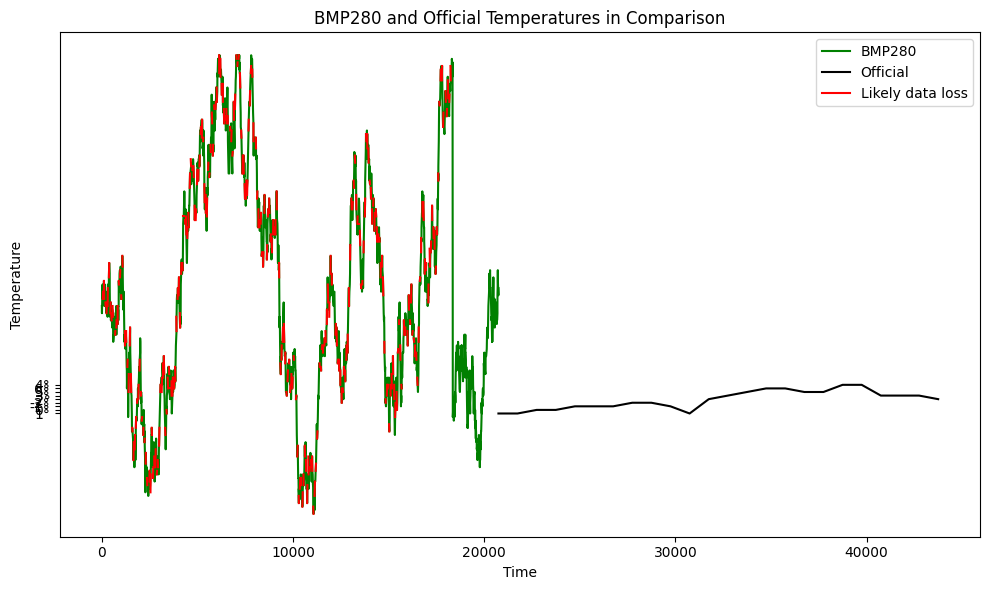

The difference between the last BMP280 and first official data is:  34.0
We have a big difference between the last BMP280 and first official data. This means that the forecast datas are not accurate and our measurements were not good as well.


In [17]:
try:
    official_datas = cansattools.get_official_data()
    official_temperatures = official_datas["temperatures"]
    official_times = official_datas["times"]
    # Adjusting timestamps
    official_times[0] = bmp280[len(bmp280)-1].time
    for i in range(1, len(official_times)):
        official_times[i] = official_times[i-1] + 1000

    # Visualize bmp280 and official temperatures
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot([bmp.time for bmp in bmp280 if not bmp.is_outlier], [bmp.temperature for bmp in bmp280 if not bmp.is_outlier], '-', color='green', label='BMP280')
    ax.plot(official_times, official_temperatures, '-', color='black', label='Official')
    ax.set_xlabel('Time')
    ax.set_ylabel('Temperature')
    ax.set_title('BMP280 and Official Temperatures in Comparison')
    first_time = True
    for i, bmp in enumerate(bmp280[1:], start=1):
        if bmp.missing_data:
            ax.plot([bmp280[i-1].time, bmp.time], [bmp280[i-1].temperature, bmp.temperature], '-', color='red', label='Likely data loss' if first_time else '') 
            first_time = False
    ax.legend()
    plt.tight_layout()
    try:
        if os.path.exists('graphs/pngs/BMP_official.png'):
            os.remove('graphs/pngs/BMP_official.png')
        plt.savefig('graphs/pngs/BMP_official.png', format='png')
        with open('graphs/pkls/BMP_official.pkl', 'wb') as file:
            pickle.dump(fig, file)
    except Exception as e:
        logger.error(f"Error saving the BMP280 and official temperatures data: {e}")
    plt.show()
    # Difference between the last BMP280 and first official data
    difference: float = bmp280[-1].temperature - float(official_temperatures[0][0])
    print("The difference between the last BMP280 and first official data is: ", difference)
    if difference > 3.0:
        print("We have a big difference between the last BMP280 and first official data. This means that the forecast datas are not accurate and our measurements were not good as well.")
    else:
        print("It seems that we only have a slight difference. This means that the forecast datas are pretty accurate and our measurements were good as well.")
except Exception as e:
    logger.error(f"Error comparing the BMP280 and official temperatures: {e}")


Note that the official datas are greatly compressed for proper illustration. They store the forecasts for one day.

### Calculating wind speed

We can try to calculate windspeed from our GPS coordinates using the attached timestamps. However, we will use plenty of simplification in order to make our goal more accomplishable.

In [18]:
timestamps = np.array([gps.time for gps in gpses if not gps.is_outlier])
x = np.array([gps.latitude for gps in gpses if not gps.is_outlier])
y = np.array([gps.longitude for gps in gpses if not gps.is_outlier])
positions = np.column_stack((x, y))

velocities = np.diff(positions, axis=0) / np.diff(timestamps)[:, np.newaxis]

# Assume simplified drag model
drag_forces = 0.5 * AIR_DENSITY * np.linalg.norm(velocities, axis=1)[:, np.newaxis]**2 * DRAG_COEFFICIENT * SURFACE_AREA

# Calculate the acceleration due to drag
acceleration_due_to_drag = drag_forces / MASS

# Calculate the wind velocity (assuming the wind is the difference between the actual velocity and the velocity without wind)
wind_velocities = velocities - acceleration_due_to_drag

# Calculate the wind speed (magnitude of the wind velocity)
wind_speeds = np.linalg.norm(wind_velocities, axis=1)

# Calculate the wind direction (in radians)
wind_directions = np.arctan2(wind_velocities[:, 1], wind_velocities[:, 0])

# Calculate the average wind speed and direction
average_wind_speed: float = np.mean(wind_speeds)
average_wind_direction: float = np.mean(wind_directions)

# Convert the average wind direction from radians to degrees
average_wind_direction_degrees = np.degrees(average_wind_direction)

print("Average Wind Speed:", round(average_wind_speed, 3), "m/s")
print("Average Wind Direction (degrees):", round(average_wind_direction_degrees, 3))

# Comparing the wind speed with the official data
official_wind_speed = official_datas["wind_speeds"][0]
print("Official Wind Speed:", official_wind_speed, "m/s")
if 0 <= average_wind_speed - official_wind_speed < 3:
    print("Our measured wind speed is slightly higher than the official data.")
elif 0 > average_wind_speed - official_wind_speed > -3 :
    print("Our measured wind speed is slightly lower than the official data.")
elif average_wind_speed - official_wind_speed >= 3:
    print("Our measured wind speed is significantly higher than the official data.")
elif average_wind_speed - official_wind_speed <= -3:
    print("Our measured wind speed is significantly lower than the official data.")

# Remove unnescessary variables
del timestamps, x, y, positions, velocities, drag_forces, acceleration_due_to_drag, wind_velocities, wind_speeds


Average Wind Speed: 0.097 m/s
Average Wind Direction (degrees): 21.888


KeyError: 'wind_speeds'

## CanSat path 3D illustration

Now that we refined the datas, let's illustrate the path of our Cansat with the additional pieces of information.

Number of missing data points:  32
Number of outliers:  35


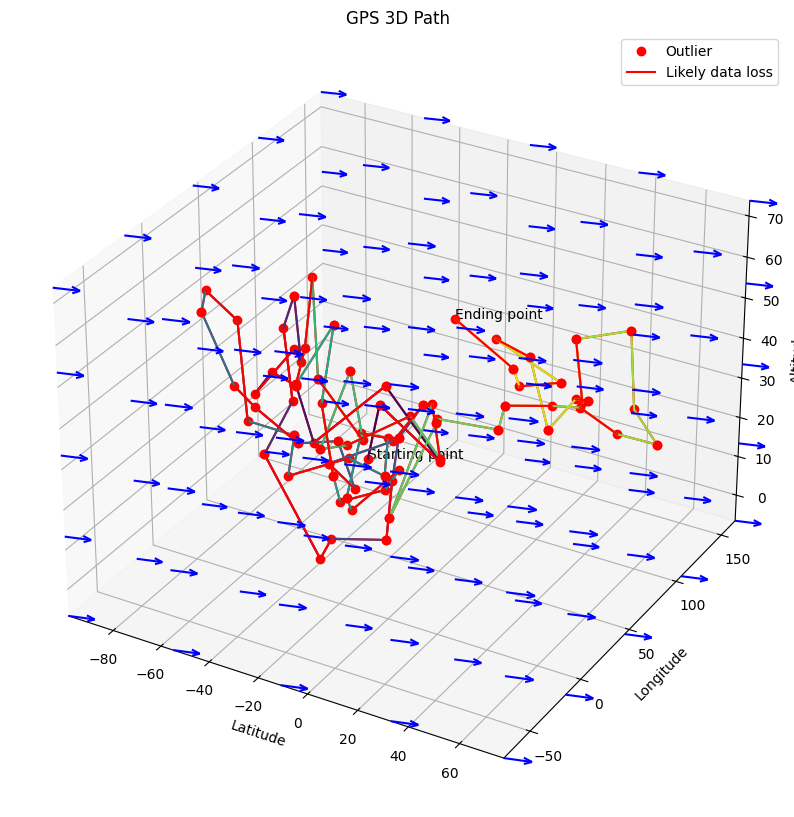

In [9]:
if TEST_DATA_MODE:
    average_wind_speed = 10
try:
    first_time = True
    first_time_outlier = True
    if len(gpses) > 0:
        print("Number of missing data points: ", sum(1 for gps in gpses if gps.missing_data))
        print("Number of outliers: ", sum(1 for gps in gpses if gps.is_outlier))
        
        # Calculate the bounds of the cube
        min_lat, max_lat = min([gps.latitude for gps in gpses]), max([gps.latitude for gps in gpses])
        min_lon, max_lon = min([gps.longitude for gps in gpses]), max([gps.longitude for gps in gpses])
        min_alt, max_alt = min([gps.altitude for gps in gpses]), max([gps.altitude for gps in gpses])

        # Create a 3D grid of points within the cube
        grid_size = 5
        lat_grid = np.linspace(min_lat - 0.1 * (max_lat - min_lat), max_lat + 0.1 * (max_lat - min_lat), grid_size)
        lon_grid = np.linspace(min_lon - 0.1 * (max_lon - min_lon), max_lon + 0.1 * (max_lon - min_lon), grid_size)
        alt_grid = np.linspace(min_alt - 0.1 * (max_alt - min_alt), max_alt + 0.1 * (max_alt - min_alt), grid_size)
        lat_grid, lon_grid, alt_grid = np.meshgrid(lat_grid, lon_grid, alt_grid)

        # Calculate the wind vectors at each point in the grid
        wind_vectors = np.zeros((grid_size, grid_size, grid_size, 3))
        for i in range(grid_size):
            for j in range(grid_size):
                for k in range(grid_size):
                    wind_vectors[i, j, k, :] = average_wind_speed * np.array([np.cos(average_wind_direction), np.sin(average_wind_direction), 0])

        # 3D path map
        fig = plt.figure(figsize=(10, 14))
        ax = plt.axes(projection='3d')
        ax.quiver(lat_grid, lon_grid, alt_grid, wind_vectors[:, :, :, 0], wind_vectors[:, :, :, 1], wind_vectors[:, :, :, 2], color='blue')
        # Plot the GPS data
        ax.plot3D([gps.latitude for gps in gpses], [gps.longitude for gps in gpses], [gps.altitude for gps in gpses], 'ro-')
        
        for i in range(len(gpses) - 1):
            ax.plot3D([gpses[i].latitude, gpses[i+1].latitude], 
                        [gpses[i].longitude, gpses[i+1].longitude], 
                        [gpses[i].altitude, gpses[i+1].altitude], 
                        color=colors[i])
        ax.text(gpses[0].latitude, gpses[0].longitude, gpses[0].altitude, 'Starting point', size=10, zorder=1, color='k')
        ax.text(gpses[-1].latitude, gpses[-1].longitude, gpses[-1].altitude, 'Ending point', size=10, zorder=1, color='k')
        ax.set_xlim(min_lat - 0.1 * (max_lat - min_lat), max_lat + 0.1 * (max_lat - min_lat))
        ax.set_ylim(min_lon - 0.1 * (max_lon - min_lon), max_lon + 0.1 * (max_lon - min_lon))
        ax.set_zlim(min_alt - 0.1 * (max_alt - min_alt), max_alt + 0.1 * (max_alt - min_alt))
        ax.set_xlabel('Latitude')
        ax.set_ylabel('Longitude')
        ax.set_zlabel('Altitude')
        ax.set_title('GPS 3D Path')

        for i, gps in enumerate(gpses[1:], start=1):
            if gps.missing_data:
                ax.plot([gpses[i-1].latitude, gps.latitude], [gpses[i-1].longitude, gps.longitude], [gpses[i-1].altitude, gps.altitude], '-', color='red', label='Likely data loss' if first_time else '')
                first_time = False
            if gps.is_outlier:
                ax.plot([gps.latitude], [gps.longitude], [gps.altitude], 'o', color='red', label='Outlier' if first_time_outlier else '')
                first_time_outlier = False
        plt.legend()
        try:
            if os.path.exists('graphs/pngs/GPS_3D_refined.png'):
                os.remove('graphs/pngs/GPS_3D_refined.png')
            plt.savefig('graphs/pngs/GPS_3D_refined.png', format='png')
            with open('graphs/pkls/GPS_3D_refined.pkl', 'wb') as file:
                pickle.dump(fig, file)
        except Exception as e:
            logger.error(f"Error saving the GPS data: {e}")
        plt.show()
except Exception as e:
    logger.error(f"Error visualizing data: {e}")



We can have a look at a 2D map to see the impact of the wind more clearly.

Number of missing data points:  32
Number of outliers:  35


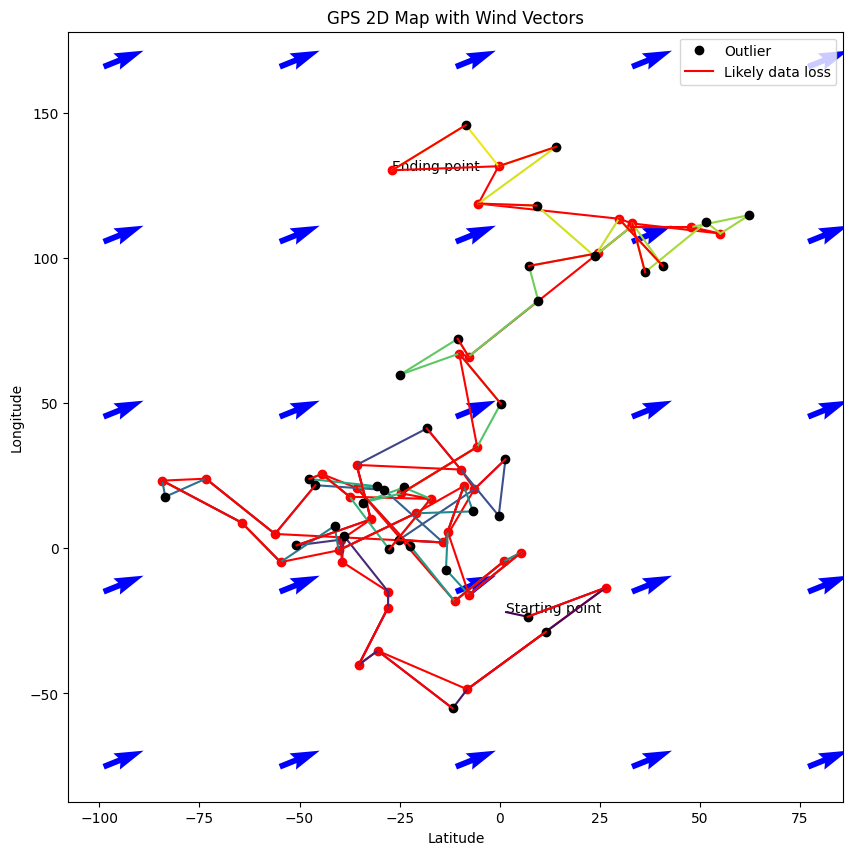

In [10]:
#2D map with wind vectors outliers and missing data
try:
    first_time = True
    first_time_outlier = True
    if len(gpses) > 0:
        print("Number of missing data points: ", sum(1 for gps in gpses if gps.missing_data))
        print("Number of outliers: ", sum(1 for gps in gpses if gps.is_outlier))
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        ax.quiver(lat_grid[:, :, 0], lon_grid[:, :, 0], wind_vectors[:, :, 0, 0], wind_vectors[:, :, 0, 1], color='blue')
        # Plot the GPS data
        ax.plot([gps.latitude for gps in gpses if not gps.is_outlier], [gps.longitude for gps in gpses if not gps.is_outlier], 'ro-')
        for i in range(len(gpses) - 1):
            ax.plot([gpses[i].latitude, gpses[i+1].latitude], [gpses[i].longitude, gpses[i+1].longitude], '-', color=colors[i])
        ax.text(gpses[0].latitude, gpses[0].longitude, 'Starting point', size=10, zorder=1, color='k')
        ax.text(gpses[-1].latitude, gpses[-1].longitude, 'Ending point', size=10, zorder=1, color='k')
        ax.set_xlabel('Latitude')
        ax.set_ylabel('Longitude')
        ax.set_title('GPS 2D Map with Wind Vectors')
        for i, gps in enumerate(gpses[1:], start=1):
            if gps.missing_data:
                ax.plot([gpses[i-1].latitude, gps.latitude], [gpses[i-1].longitude, gps.longitude], '-', color='red', label='Likely data loss' if first_time else '')
                first_time = False
            if gps.is_outlier:
                ax.plot([gps.latitude], [gps.longitude], 'o', color='red', label='Outlier' if first_time_outlier else '')
                first_time_outlier = False
        plt.legend()
        try:
            if os.path.exists('graphs/pngs/GPS_2D_refined.png'):
                os.remove('graphs/pngs/GPS_2D_refined.png')
            plt.savefig('graphs/pngs/GPS_2D_refined.png', format='png')
            with open('graphs/pkls/GPS_2D_refined.pkl', 'wb') as file:
                pickle.dump(fig, file)
        except Exception as e:
            logger.error(f"Error saving the GPS data: {e}")
        plt.show()
except Exception as e:
    logger.error(f"Error visualizing data: {e}")

# Remove unnescessary variables
del lat_grid, lon_grid, alt_grid, wind_vectors, min_lat, max_lat, min_lon, max_lon, min_alt, max_alt

## Convert Notebook into a pdf

For people who cannot open the Notebook due to the lack of environment setup we should convert our analyzis into a PDF file.
This code tries to create Visualization.pdf which contains the whole analyzis with the scripts. This process takes approximately 3 minutes to complete. If you would like to skip the conversion, set INTO_PDF constant to false.

In [11]:
if INTO_PDF:
    try:
        subprocess.run(f"python -m jupyter nbconvert --to pdf --output Visualization.pdf Visualization.ipynb", shell=True, check=True, timeout=600)
        print("Exporting to PDF...")
    except Exception as e:
        logger.error(f"Error exporting the notebook into pdf format: {e}")
    if os.path.exists("Visualization.pdf"):
        print("PDF exported successfully.")
    else:
        print("PDF export failed.")
        logger.error("PDF export failed.")
else:
    print("PDF export skipped.")

PDF export skipped.
